# Making Random Numbers

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 07-11-2018 (latest update)
***

Python script for illustrating the two methods for generating random numbers according to a known PDF, starting with random uniformly distributed numbers:
- Transformation method (if function can be integrated and then inverted).
- Hit & Miss (or Accept-Reject) method (by Ulam Stanislav and John Von Neumann).

The function used for illustration is: $f(x) = x^3$, in the interval $[0, C]$ where $C$ is a number that ensures that the function if properly normalized.

For more information see:
-    G. Cowan: Chapter 3
-    P. R. Bevington: page 81-84
***

First, we import the modules we want to use:

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import BinnedLH, Chi2Regression, Extended # Helper tool for fitting
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load the external functions. In addition, we also define our own function that bins 1D-data and returns the centers (`x`), entries (`y`) and their uncertainties (`sy`) along with a mask which masks out the empty bins:

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

def bin_data(x, bins, xmin, xmax):

    hist_y, hist_edges = np.histogram(x, bins=bins, range=(xmin, xmax))
    hist_x = 0.5*(hist_edges[1:] + hist_edges[:-1])
    hist_sy = np.sqrt(hist_y)
    hist_mask = hist_y > 0
    
    return hist_x, hist_y, hist_sy, hist_mask

Set the parameters of the program. Try setting the random seed to another value and rerun the program to see how much this changes:

In [3]:
# Random numbers
r = np.random
r.seed(21) # try also another value - how much does this change?

save_plots = False

# Set parameters:
N_numbers = 100000       # Number of random numbers produced.

# Constant for f(x) = x^3 in [1, constant] to be normalised:
constant = 5**(1/4)

# Histogram settings (note the choice of 120 bins):
N_bins = 120
xmin = 1
xmax = constant

## Generate numbers 

According to PDF $f(x) = x^3$ in $[0, C]$ using both the transformation method and the hit & miss method:

In [4]:
x_trans   = np.zeros(N_numbers)
x_hitmiss = np.zeros(N_numbers)

for i in range(N_numbers):

    # Transformation method:
    # ----------------------
    # Integration gives the function F(x) = 1/4 x^4 + 1/4, which inverted gives F^-1(y) = (4y+1)**(1/4):
    x_trans[i] = (4*r.uniform()+1)**(1/4)

    # Hit & Miss method:
    # ------------------
    # Generate two random numbers uniformly distributed in [1,c] x [0,c^3], until they
    # fulfill the "Hit requirement" (and start with numbers, that DON'T fullfill it!):
    x_hitmiss[i] = 0.0
    y = 1.0
    while (x_hitmiss[i]**3 < y) :      # ...so keep making new numbers, until this is fulfilled!
        x_hitmiss[i] = r.uniform(1, constant)
        y  = r.uniform(0, constant**3)

Having generated the numbers according to $f(x)$ with the two transformation methods, we now bin the data to be able to plot them. 

First the transformation method-generated data:

In [5]:
hist_trans_x_all, hist_trans_y_all, hist_trans_sy_all, hist_trans_mask = bin_data(x_trans, N_bins, xmin, xmax)

hist_trans_x = hist_trans_x_all[hist_trans_mask]
hist_trans_y = hist_trans_y_all[hist_trans_mask]
hist_trans_sy = hist_trans_sy_all[hist_trans_mask]

and then the hit & miss-generated data:

In [6]:
hist_hitmiss_x_all, hist_hitmiss_y_all, hist_hitmiss_sy_all, hist_hitmiss_mask = bin_data(x_hitmiss, N_bins, xmin, xmax)

hist_hitmiss_x = hist_hitmiss_x_all[hist_hitmiss_mask]
hist_hitmiss_y = hist_hitmiss_y_all[hist_hitmiss_mask]
hist_hitmiss_sy = hist_hitmiss_sy_all[hist_hitmiss_mask]

## Plot histograms on screen:

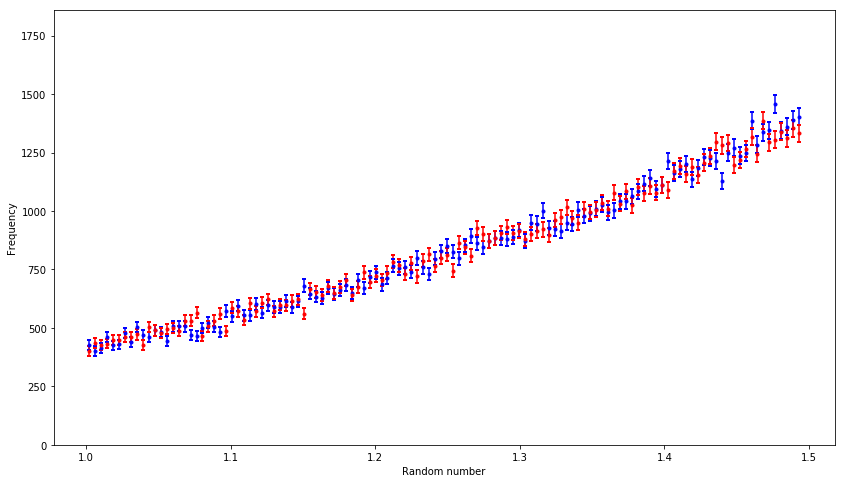

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(hist_trans_x, hist_trans_y, hist_trans_sy,       fmt='b.', capsize=2, capthick=2, label="Transformation")
ax.errorbar(hist_hitmiss_x, hist_hitmiss_y, hist_hitmiss_sy, fmt='r.', capsize=2, capthick=2, label="Hit & Miss")
ax.set(ylim=(0, ax.get_ylim()[1]*1.2), xlabel="Random number", ylabel="Frequency");

Now we define the function that we want to fit the data to:

In [8]:
def fit_func(x, m, c):
    return m*x**3 + c

### Transformation method:
Fitting histogram with transformation numbers:

In [9]:
chi2_object_trans = Chi2Regression(fit_func, hist_trans_x, hist_trans_y, hist_trans_sy)
minuit_trans = Minuit(chi2_object_trans, pedantic=False)

minuit_trans.migrad();
chi2_trans = minuit_trans.fval
ndof_trans = len(hist_trans_x) - len(minuit_trans.args)
prob_trans = stats.chi2.sf(chi2_trans, ndof_trans)

FCN = 132.79503533449287 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 4.990641475120838e-20 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,m,416.525,3.8981,,,,,No
1,c,-8.64228,7.40595,,,,,No


And plot it on the data:

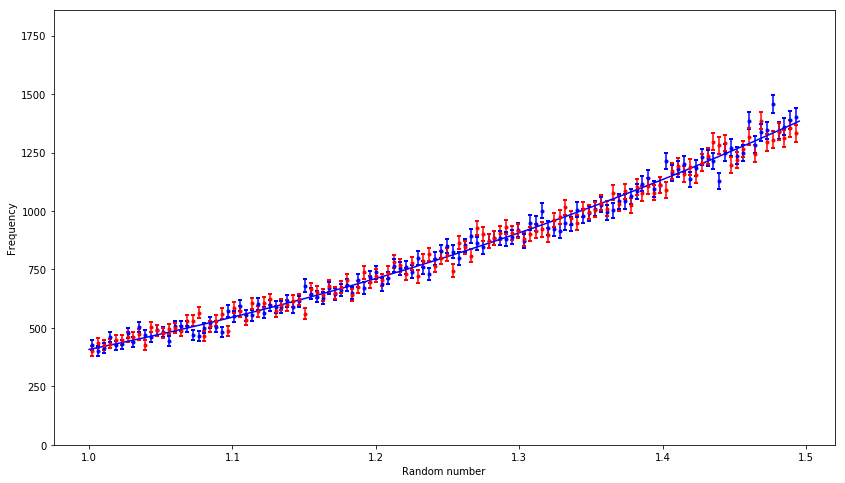

In [10]:
x_fit = np.linspace(xmin, xmax, 1000)

y_fit_trans = fit_func(x_fit, *minuit_trans.args)

ax.plot(x_fit, y_fit_trans, 'b-')
fig

### Hit & Miss method:
Fitting histogram with hit & miss numbers:

In [11]:
chi2_object_hitmiss = Chi2Regression(fit_func, hist_hitmiss_x, hist_hitmiss_y, hist_hitmiss_sy)
minuit_hitmiss = Minuit(chi2_object_hitmiss, pedantic=False)

minuit_hitmiss.migrad();
chi2_hitmiss = minuit_hitmiss.fval
ndof_hitmiss = len(hist_hitmiss_x) - len(minuit_hitmiss.args)
prob_hitmiss = stats.chi2.sf(chi2_hitmiss, ndof_hitmiss)

FCN = 136.0961717257763 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 1.684331645793454e-20 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,m,407.769,3.89592,,,,,No
1,c,9.00509,7.42113,,,,,No


and plot it:

In [12]:
y_fit_hitmiss = fit_func(x_fit, *minuit_hitmiss.args)
ax.plot(x_fit, y_fit_hitmiss, 'r-')

however, before we show the plot, we add a legend to the figure and the fit results:

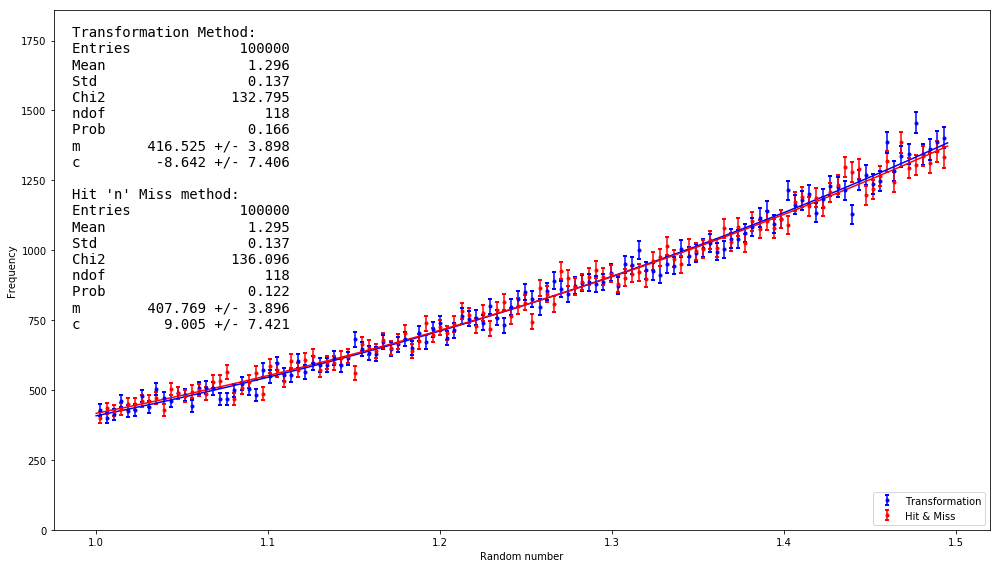

In [13]:
d_trans = {'Entries': len(x_trans),
           'Mean': x_trans.mean(),
           'Std': x_trans.std(ddof=1),
           'Chi2': chi2_trans,
           'ndof': ndof_trans,
           'Prob': prob_trans, 
           'm': [minuit_trans.values['m'], minuit_trans.errors['m']],
           'c': [minuit_trans.values['c'], minuit_trans.errors['c']],
           }

d_hitmiss = {'Entries': len(x_hitmiss),
           'Mean': x_hitmiss.mean(),
           'Std': x_hitmiss.std(ddof=1),
           'Chi2': chi2_hitmiss,
           'ndof': ndof_hitmiss,
           'Prob': prob_hitmiss, 
           'm': [minuit_hitmiss.values['m'], minuit_hitmiss.errors['m']],
           'c': [minuit_hitmiss.values['c'], minuit_hitmiss.errors['c']],
           }

# fit results text
text_trans = nice_string_output(d_trans, extra_spacing=2, decimals=3)
text_hitmiss = nice_string_output(d_hitmiss, extra_spacing=2, decimals=3)
text = f"Transformation Method: \n{text_trans}  \n\nHit 'n' Miss method: \n{text_hitmiss}"

# add fit result text on the plot
add_text_to_ax(0.02, 0.97, text, ax, fontsize=14)

# Legend:
ax.legend(loc='lower right')
fig.tight_layout()

if save_plots: 
    fig.savefig("Hist_TransVsHitMiss_solution.pdf", dpi=600)
    
fig

## Probability calculation

Calculate the probability that these two distributions are the same using a $\chi^2$ probability and with a binned / unbinned Kolmogorov test:

In [14]:
# makes sure that at least one of the two histograms is represented in each bin
common_indexes = hist_trans_mask | hist_hitmiss_mask 
p_chi2 = stats.chi2_contingency([hist_trans_y_all[common_indexes], hist_hitmiss_y_all[common_indexes]])[1]

# we need to find the original values from the histogram (now binned) approximately. Can be seen as a lossy reversion
center_repeated_trans = np.repeat(hist_trans_x_all[common_indexes], hist_trans_y_all[common_indexes])
center_repeated_hitmiss = np.repeat(hist_hitmiss_x_all[common_indexes], hist_hitmiss_y_all[common_indexes])

p_kolm_binned = stats.ks_2samp(center_repeated_trans, center_repeated_hitmiss)
p_kolm = stats.ks_2samp(x_trans, x_hitmiss)

print("\nThe probability of the two distributions being the same is:")
print(f"Chi-Square:  p = {p_chi2:6.4f}   Kolmogorov (binned):  p = {p_kolm_binned[1]:6.4f}   Kolmogorov (unbinned):  p = {p_kolm[1]:6.4f}")
print("\nNOTE: We will get to what the 'Kolmogorov Test' is...")


The probability of the two distributions being the same is:
Chi-Square:  p = 0.0105   Kolmogorov (binned):  p = 0.1720   Kolmogorov (unbinned):  p = 0.1435

NOTE: We will get to what the 'Kolmogorov Test' is...


***

One quick note about the K-S test: It will over-estimate the p-value for
roughly binned data! Try with ten (or hundred!) times more bins.

***

Cern's ROOT documentation has this to say about the K-S test on binned data:
(Jan Conrad, Fred James):

> "The returned value PROB is calculated such that it will be uniformly distributed between zero and one for compatible histograms,
provided the data are not binned (or the number of bins is very large compared with the number of events). Users who have access to unbinned data and wish
exact confidence levels should therefore not put their data into histograms, but should call directly TMath::KolmogorovTest. On the other hand, since TH1
is a convenient way of collecting data and saving space, this function has been provided. However, the values of PROB for binned data will be shifted
slightly higher than expected, depending on the effects of the binning. For example, when comparing two uniform distributions of 500 events in 100 bins,
the values of PROB, instead of being exactly uniformly distributed between zero and one, have a mean value of about 0.56. We can apply a useful rule:
As long as the bin width is small compared with any significant physical effect (for example the experimental resolution) then the binning cannot have an
important effect. Therefore, we believe that for all practical purposes, the probability value PROB is calculated correctly provided the user is aware that:
>1.  The value of PROB should not be expected to have exactly the correct
    distribution for binned data.
>2.  The user is responsible for seeing to it that the bin widths are small
    compared with any physical phenomena of interest.
>3.  The effect of binning (if any) is always to make the value of PROB slightly
    too big. That is, setting an acceptance criterion of (PROB>0.05 will assure
    that at most 5% of truly compatible histograms are rejected, and usually
    somewhat less."

# Questions:

1) Make sure that you understand how the two methods works! What is the efficiency of each of the methods? 

2) Compare the two histograms - are they from the same distribution? Answer by first comparing the fit parameters, and see if they overlap. Afterwards, calculate the Chi2 between the two histograms (i.e. the difference divided by the uncertainty bin by bin), and compare this to the number of degrees of freedom.

3) Try to repeat the exercise with the function f(x) = x^3 in the range [1,C], (perhaps in a new file, so that you save this macro), where C is a number, which ensures that the PDF f(x) is normalized. Think about what changes. Again compare the two histograms.